In [1]:
%matplotlib inline

In [2]:
import random
import torch
from d2l import torch as d2l

# 构造人造数据集

In [3]:
def synthetic_data(w, b, num_examples):
    """
    生成 y = Xw + b + 噪声
    """
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [4]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([0.5830, 0.7518]) 
label: tensor([2.8172])


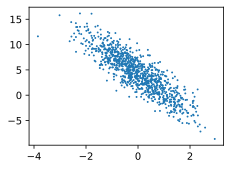

In [5]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)

In [6]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i+batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.8505, -0.4320],
        [-0.2574, -0.9178],
        [ 0.2338, -0.9056],
        [ 0.8497,  0.3243],
        [ 0.7258, -0.5871],
        [ 0.6269, -0.2765],
        [ 0.4952,  0.9476],
        [ 0.3461,  0.6374],
        [-1.1829,  1.4385],
        [-1.5202, -0.3831]]) 
 tensor([[ 7.3689],
        [ 6.8137],
        [ 7.7493],
        [ 4.7988],
        [ 7.6627],
        [ 6.3919],
        [ 1.9596],
        [ 2.7253],
        [-3.0486],
        [ 2.4814]])


# 定义模型

In [7]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [8]:
def linreg(X, w, b):
    return torch.matmul(X, w) + b

# 定义损失函数

In [9]:
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

# 定义优化算法

In [12]:
def sgd(params, lr, batch_size):
    """
    小批量随机梯度下降
    """
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

# 训练过程

In [13]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch+1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.025687
epoch 2, loss 0.000090
epoch 3, loss 0.000049


In [14]:
print(f'w的估计误差：{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b-b}')

w的估计误差：tensor([-0.0006,  0.0005], grad_fn=<SubBackward0>)
b的估计误差：tensor([-8.1062e-06], grad_fn=<RsubBackward1>)


# 线性回归简洁实现

In [15]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 100)

In [16]:
def load_array(data_arrays, batch_size, is_train=True):
    """
    构造一个pytorch数据迭代器
    """
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

next(iter(data_iter))

[tensor([[-1.4661, -0.2121],
         [ 0.2068, -0.3985],
         [ 1.6216,  1.6231],
         [ 1.2452,  1.2554],
         [-2.3501,  0.6785],
         [ 0.6472, -0.2953],
         [ 0.0043,  0.0207],
         [ 0.5067, -0.9497],
         [ 0.7865,  1.4207],
         [ 0.0776,  0.4390]]),
 tensor([[ 1.9863],
         [ 5.9801],
         [ 1.9261],
         [ 2.4448],
         [-2.7991],
         [ 6.4969],
         [ 4.1178],
         [ 8.4515],
         [ 0.9476],
         [ 2.8695]])]

## 使用框架的预定义好的层

In [17]:
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

## 初始化模型参数

In [18]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

## 计算均方误差

In [19]:
loss = nn.MSELoss()

## 实例化SGD实例

In [20]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

## 训练

In [26]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad();
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch+1}, loss {l:f}')

epoch 1, loss 0.000091
epoch 2, loss 0.000091
epoch 3, loss 0.000091
